# Feature Engineering
-------------------
In this notebook I will explore the data more to see what potential predictive features can be found in the dataset.
### Challenges

Linke any real world dataset, there are some characteristics that make relatively the classification task a little bit harder:
* My investigation reveals that there are a lot of **non-native-language** comments that are to some extent shifted away from - let’s say - more standard english writing style.
* There are many **typos** and **unfinished sentences** in the dataset.
* I decided this to be a **multi-class problem**. The fact is the middle class (which I call it `Disengaged`) are more or less similar to either of two other classes (`Stoked` or `Dissatisfied`). This will probably make it harder for model to separate and cluster the middle class from others.
* SEEK’s method to submit reviews is asking for `pros` and `cons` separately. This has encouraged users to drop their opinion more like a list of things rather than comprehensive complete sentences. For example: someone in response to `cons` may write “salary, management” which bears no sentiment when the `cons` tag is removed.

### NLP Engine

I will use [spaCy](https://spacy.io/) to transform the text data into vectors. Although vectors are here mainly used for visualization, I will keep using spaCy later during model development

In [1]:
import umap
import spacy
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from bokeh.plotting import output_notebook, show
from pathlib import Path
import sys
sys.path.append("..")
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from rustoked.data_processing import(
    clean_raw_dataframe,
    get_labels,
    get_normalized_series
)

from rustoked.visual_utils import(
    get_visual_df, 
    get_interactive_vec_plot,
    get_vec_plot
)

/home/sakima/Projects/RUStoked/.venv/lib/python3.6/site-packages/umap/spectral.py:4: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  import numba.targets


First let’s load the data into a `pandas dataframe` and preprocess as I did in the [data exploration notebook](https://github.com/mohsen-saki/RUStoked/blob/master/notebooks/data_exploration.ipynb).

Dataset is splitted in `train` and `test` batches.

`spaCy` is used to get the `vector`s for reviews’ text.

Vectors are mapped to a two dimensional vector using `UMAP` for the sake of visualisation and data exploration.

I used the `matplotlib` version of plots here to ease upload to github. Feel free to run the `bokeh` version for interactive plot.

In [2]:
df = pd.read_csv(Path("../data/raw_data.csv"))
df = clean_raw_dataframe(df.copy())

train_df, test_df = train_test_split(df, test_size=0.3, random_state=69)

nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner"])
umapper = umap.UMAP()

spacy_emb = train_df["reviews"].apply(lambda x: nlp(x).vector)
stack_emb = np.vstack(spacy_emb)
umap_emb = umapper.fit_transform(stack_emb)

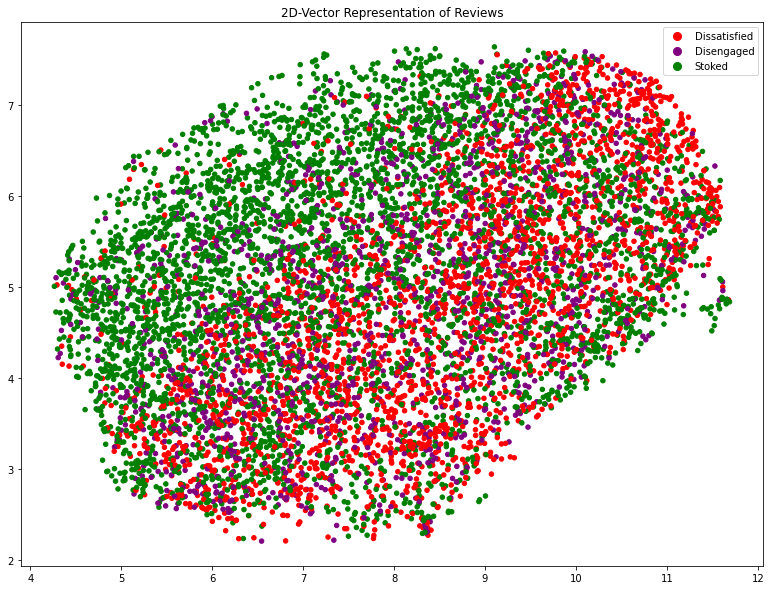

In [3]:
visual_df = get_visual_df(umap_emb, train_df)


# Uncomment this to get the interactive bokeh plot
"""
output_notebook()
plot = get_interactive_vec_plot(visual_df)
show(plot)
"""
# Uncomment this to get pyplot instance
get_vec_plot(visual_df)

In [4]:
# to get the data row for targeted data point from plot above based on index 
train_df[train_df.index==5209]

,job_title,recommendation,salary,date,location,career_opportunity_rating,work_life_balance_rating,work_env_rating,management_rating,benefits_rating,diversity_rating,overall_rating,company,reviews,calculated_rating,labels,review_len
5209,Associate Director,No,Low,6 months ago,"Sydney NSW, Australia",1,1,3,2,1,1,1,KPMG,‘It's good for networking and bad for career p...,2.0,0,371


From the above plot, I would say that a noticeable part of `class-2` labels are already separated or clustered by the `spaCy NLP model`. However, my further investigation shows that there are some set of words which are more frequent in each of labels:

* positive descriptive words are more common with positive reviews. Such as **`great`** and **`good`**.

* Conjunction word **`but`** is more frequent with let say neutral reviews which is used to link `pros` and `cons` in those `class-1` reviews.

* As expected, negative function words such as **`not`**, **`no`**, and **do`n’t`** can mostly be observed between `class-0` of reviews.

* Also negative descriptive words such as **`poor`** and **`bad`** appear more often in negative tone reviews.

The other feature that I checked out here is **`review length`**. From the [data exploration](https://github.com/mohsen-saki/RUStoked/blob/master/notebooks/data_exploration.ipynb) stage, I can say `class-1` reviews slightly tend to be longer.

In [5]:
# use following code to check if a specific word is more frequent in 
# a label category comparing to the total number of that label.

train_df[
    train_df["reviews"].str.lower().str.contains("good", regex=False) |
    (train_df["reviews"].str.lower().str.contains("great", regex=False))
]["labels"].value_counts().sort_index() / train_df["labels"].value_counts().sort_index()



0    0.446568
1    0.619398
2    0.669161
Name: labels, dtype: float64

I consider two approaches to plug in above predictive feature candidates:

1. First, I will create some new columns containing `bool` value if each review has the targeted word in it. It is expected that labels which benefit from those words separate further in their own clusters.

2. Second, I will conduct a kind of penalty approach. This is because some of those reviews contain more than one occurrence of a specific word like `great` or `poor`. So each review will get a plus or minus of number of occurrences for each of those targeted words based on being considered positive or negative. Then total sum will account for a `weight factor` to be included in word vectors.

In [6]:
# creat a new column with review length normalized
train_df["norm_review_len"] = get_normalized_series(df, "review_len")

# creating new columns each containing if targeted word is in the review or not
train_df["has_positive"] = (
    train_df["reviews"].str.lower().str.contains("great", regex=False) |
    train_df["reviews"].str.lower().str.contains("good", regex=False)
)

train_df["has_but"] = train_df["reviews"].str.lower().str.contains("but", regex=False)

train_df["has_negative"] = (
    train_df["reviews"].str.lower().str.contains("bad", regex=False) |
    train_df["reviews"].str.lower().str.contains("poor", regex=False) |
    train_df["reviews"].str.lower().str.contains("not", regex=False) |
    train_df["reviews"].str.lower().str.contains("no", regex=False) |
    train_df["reviews"].str.lower().str.contains("n't", regex=False)
)

# creating new columns each containing number of occurrences for each targeted 
# word is in the review and total sum of all as a weight factor.
train_df["great_count"] = train_df["reviews"].str.lower().str.count("great")
train_df["good_count"] = train_df["reviews"].str.lower().str.count("good")

train_df["bad_count"] = -train_df["reviews"].str.lower().str.count("bad")
train_df["poor_count"] = -train_df["reviews"].str.lower().str.count("poor")
train_df["not_count"] = -train_df["reviews"].str.lower().str.count("not")
train_df["no_count"] = -train_df["reviews"].str.lower().str.count("no")
train_df["n't_count"] = -train_df["reviews"].str.lower().str.count("n't")

# total sum based on their content tendency as positive(+) or negative(-)
train_df["pos_neg_factor"] = train_df[["great_count", "good_count", 
                                       "bad_count", "poor_count", "not_count", 
                                       "no_count", "n't_count"]].sum(axis=1)

# get the normalized weight factor
train_df["norm_factor"] = get_normalized_series(train_df, "pos_neg_factor")

Time to see how it will affect label’s clustering. I will plug features kind of step by step into the word vector and visualize it to see how things are going.

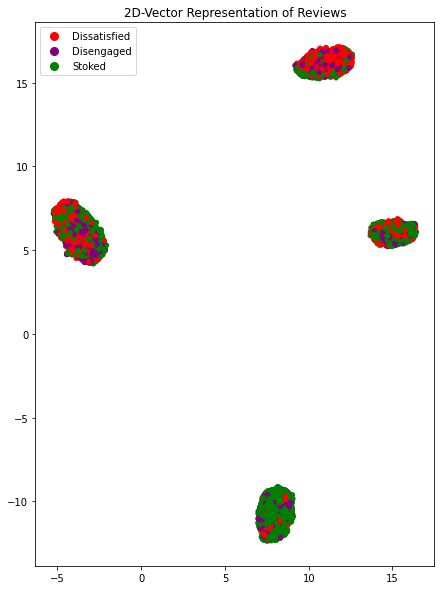

In [7]:
# approach#1, having "positive" or "negative" set of words
features_vec = np.append(np.array(stack_emb), train_df[["has_positive", "has_negative"]], 1)

embeddings = umapper.fit_transform(features_vec)

visual_df = get_visual_df(embeddings, train_df)

get_vec_plot(visual_df)

Well, it seems at least two clusters mainly containing `class-0` or `class-2` labels are separated. Let's add other features: `having word “but”` and the other one `“review length”` 

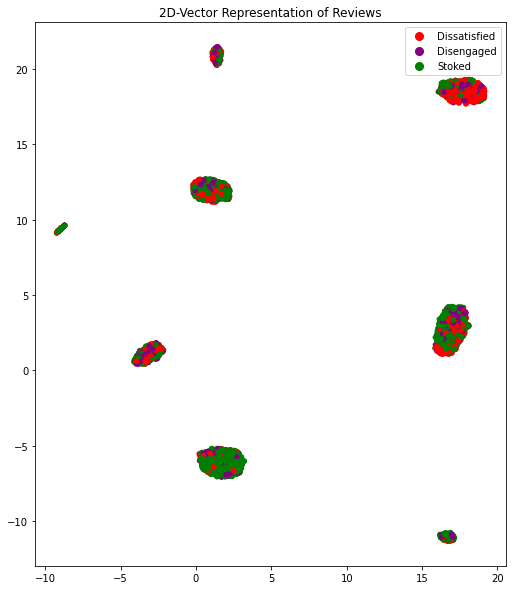

In [8]:
# approach#1, having "positive" or "negative" set of words, also word "but"
features_vec = np.append(np.array(stack_emb), train_df[["has_positive", "has_negative", "has_but"]], 1)

embeddings = umapper.fit_transform(features_vec)

visual_df = get_visual_df(embeddings, train_df)

get_vec_plot(visual_df)

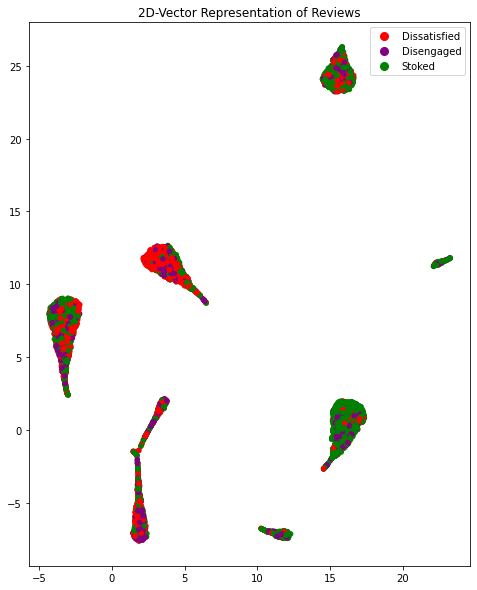

In [9]:
# approach#1, all features including review length
features_vec = np.append(np.array(stack_emb), train_df[["has_positive", "has_negative", 
                                                        "has_but", "norm_review_len"]], 1)

embeddings = umapper.fit_transform(features_vec)

visual_df = get_visual_df(embeddings, train_df)

get_vec_plot(visual_df)

Seems there are some clusters containing a majority of `class-1` labels.
 
Let's continue with **second approach**

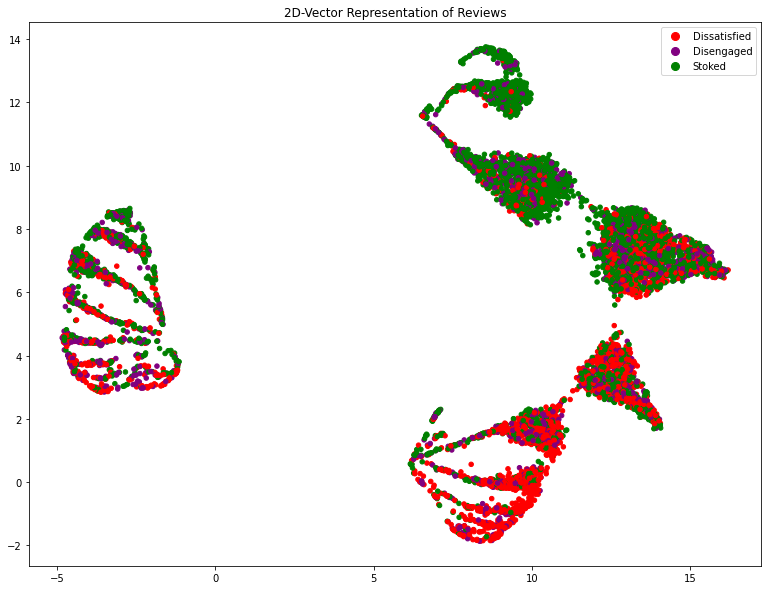

In [10]:
# approach#2, includong all features
features_vec = np.append(np.array(stack_emb), train_df[["norm_factor", 
                                                        "has_but", "norm_review_len"]], 1)

embeddings = umapper.fit_transform(features_vec)

visual_df = get_visual_df(embeddings, train_df)

get_vec_plot(visual_df)

Next I will continue with model development to see how it performs on features.